MECANISMO CUATRO BARRAS 

PROBLEMAS VELOCIDAD Y ACELERACIÓN

PASO 1: MATRIZ JACOBIANA

Para resolver el problema velocidad, necesitamos otra vez la matriz jacobiana. El método de construcción aparece detallado en el notebook Problema_Posición_4B, por lo que para este caso copiaremos el código de los pasos realizados para poder conseguirla.

In [30]:
#PASO 1
import numpy as np
import math as math
#import array as arr
import pprint  
import matplotlib.pyplot as plt  
import matplotlib.animation as animation
import scipy.integrate as integrate 
import os
from time import sleep
%matplotlib inline  


print ('MECANISMO DE CUATRO BARRAS')
print ('=============================')
# Lectura de datos por teclado

meca = {} # dictionary vacio, con propiedades de mecanismo

meca["L1"] = float (input ('Introduce longitud L1:'))
meca["L2"] = float (input ('Introduce longitud L2:'))
meca["L3"] = float (input ('Introduce longitud L3:'))
meca["theta"] = float (input ('Introduce angulo inicial theta:')) #En rad
meca["XB"] = float (input ('Introduce coordenada en x del punto B:'))
meca["XA"] = 0
meca["YA"] = 0
meca["YB"] = 0

# Defino posicion inicial:
q = np.array ([[0.1], [meca["L1"]], [1], [0.2], [meca["theta"]]])
#print('q: ' + str(q))

# JACOBIANO
def jacob_Phiq(q,meca):
    #Inicializa a cero la matriz jacobiana
    Jacob = np.zeros((5,5))

    #Extraer coordenadas

    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    #Montar matriz

    Jacob[0,0] = 2*X1
    Jacob[0,1] = 2*Y1
    Jacob[1,0] = -2*(X2-X1)
    Jacob[1,1] = -2*(Y2-Y1)
    Jacob[1,2] = 2*(X2-X1)
    Jacob[1,3] = 2*(Y2-Y1)
    Jacob[2,2] = -2*(meca["XB"]-X2)
    Jacob[2,3] = -2*(0-Y2)

    if (math.cos(theta) < (math.sqrt(2)/2) ):
        Jacob[3,4] = meca["L1"]*math.sin(theta)
        Jacob[3,0] = 1
    else:
        Jacob[3,4] = -meca["L1"]*math.cos(theta)
        Jacob[3,1] = 1


    Jacob[4,4] = 1

    return Jacob


def Phi (q,meca):
    #Inicializa a cero Phi
    Phi = np.zeros((5,1))

    #Extraer coordenadas
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]

    Phi[0] = X1**2 + Y1**2 - meca["L1"]**2
    Phi[1] = (X2-X1)**2 + (Y2-Y1)**2 -meca["L2"]**2
    Phi[2] = (meca["XB"]-X2)**2 + Y2**2 - meca["L3"]**2

    if (math.cos(theta) < (math.sqrt(2)/2) ):
        Phi[3] = X1-meca["L1"]*math.cos(theta)
    else: 
        Phi[3] = Y1-meca["L1"]*math.sin(theta)

    return Phi



def resuelve_prob_posicion(q_init, meca):
    #Inicializacion de variables
    error = 1e10
    tolerancia = 1e-10

    #Inicializacion en cero de deltaQ, fi y q
    deltaQ = np.zeros ((5,1))
    q = q_init
    i=0

    # Iteraciones hasta conseguir que el error sea menor que la tolerancia

    while (error > tolerancia and i<=100):
        #print("q=")
        #pprint.pprint(q)


        #Extraer las coordenadas
        X1 = q[0]
        Y1 = q[1]
        X2 = q[2]
        Y2 = q[3]
        theta = q[4]
       
        fi=Phi(q,meca)
        #print ("Phi" + "=")
        #pprint.pprint(fi)
        J = jacob_Phiq(q,meca)
        #print ("jacob" + "=")
        #pprint.pprint(J)
        #rango = np.linalg.matrix_rank(J, 1e-5)
        #print("rango=" + str(rango) + "\n") #Si el rango es menor que el numero de filas no tiene solucion
        
        deltaQ = np.linalg.solve(J,-fi)
        q = q + deltaQ
        error = np.linalg.norm(deltaQ)  # El error es el modulo del vector
        i=i+1

        
        #print("error iter" + str(i) + "=")
        #pprint.pprint(error)
    #print("num iters:" + str(i))
    return q

resuelve_prob_posicion (q,meca)
J = jacob_Phiq(q,meca)
print ("Jacob=")
pprint.pprint(J)

MECANISMO DE CUATRO BARRAS
Introduce longitud L1:1
Introduce longitud L2:2
Introduce longitud L3:3
Introduce angulo inicial theta:1
Introduce coordenada en x del punto B:2
Jacob=
array([[ 0.2       ,  2.        ,  0.        ,  0.        ,  0.        ],
       [-1.8       ,  1.6       ,  1.8       , -1.6       ,  0.        ],
       [ 0.        ,  0.        , -2.        ,  0.4       ,  0.        ],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.84147098],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ]])


PASO 2: PROBLEMA VELOCIDAD

Consiste en determinar las velocidades de todas las variables del mecanismmo una vez sabemos su posición q y la velocidad de los grados de libertad. 

Partimos de la ecuación:

Jacob · qp = -Phip

Siendo qp el vector velocidad, Jacob el jacobiano y Phip la derivada parcial de las ecuaciones de restricción respecto al tiempo. Para las ecuaciones de sólido rígido el valor de esta derivada es 0. Solo tendría un valor no nulo la correspondiente al ángulo, que en ese caso tendría la velocidad que nosotros le indiquemos. 

En este caso vamos a tomar un valor de 1. 

Por lo tanto, tendríamos:

qp = Jacob/Phip 

In [31]:
#PASO 2

def resuelve_prob_velocidad(q,meca):
    
    b = np.zeros ((5,1))
    #Velocidad del gdl. En una vuelta completa del angulo se cumple angulo=2*Pi*t
    b[4]=1
    qp = np.linalg.solve(jacob_Phiq(q,meca),b)
    #print ("qp=")
    #pprint.pprint(qp)
 
    return qp

resuelve_prob_velocidad (q,meca)

array([[-0.84147098],
       [ 0.0841471 ],
       [ 0.26601341],
       [ 1.33006704],
       [ 1.        ]])

PASO 3: PROBLEMA ACELERACION

El problema aceleración trata de determinar las aceleraciones de todas las variables del mecanismo, conociendo la posición q, la velocidad qp y las aceleraciones de los grados de libertad. 

La ecuación de la que partimos es:

Jacob · qpp = -dev_Jacob · qp

Siendo Jacob el jacobiano, qpp el vector aceleración, qp el vector velocidad y dev_Jacob la derivada del jacobiano respecto al tiempo. 

Es decir, si llamamos b al conjunto dev_Jacob·qp tendríamos como resultado:

qpp = -Jacob/b

In [32]:
#PASO 3

def resuelve_prob_aceleracion (q,meca):

    b=np.zeros ((5,1))
    qp = resuelve_prob_velocidad (q,meca)

    #Extraer las posiciones
    X1 = q[0]
    Y1 = q[1]
    X2 = q[2]
    Y2 = q[3]
    theta = q[4]
    #Extraer las velocidades
    X1q = qp[0]
    Y1q = qp[1]
    X2q = qp[2]
    Y2q = qp[3]
    thetaq = qp[4]
    
    b[0] = 2*(X1q)**2 + 2*(Y1q)**2
    b[1] = 2*(X1q**2+X2q**2) + 2*(Y1q**2 + Y2q**2) - 2*X1q*X2q - 2*Y1q*Y2q
    b[2] = 2*X2q**2 + 2*Y2q**2
    
    if (math.cos(theta) < (math.sqrt(2)/2) ):
        b[3] = thetaq * (meca["L1"] * math.cos(theta))
    else: 
        b[3] =  thetaq * (meca["L1"] * math.sin(theta))
    
    b[4] = 1 #Aceleracion conocida 
    qpp = np.linalg.solve(-jacob_Phiq(q,meca),b)
    #print ("qpp=")
    #pprint.pprint(qpp)	
     
    return qpp

resuelve_prob_aceleracion(q, meca)

array([[ 0.30116868],
       [-0.74527102],
       [ 2.95452069],
       [ 5.57339612],
       [-1.        ]])

PASO 4: GRÁFICAS DE VELOCIDADES

Vamos a representar por separado la gráfica de la velocidad en cada coordenada (X1, Y1, X2 e Y2).


VX1=
array([-10.        ,  -9.91789975,  -9.67294711,  -9.2691642 ,
        -8.71318116,  -8.01412725,  -7.18348098,  -0.78183279,
        -0.85514401,  -0.91441372,  -0.95866871,  -0.98718231,
        -0.99948633,  -0.99537874,  -0.97492698,  -0.93846687,
        -0.88659709,  -0.82016934,  -0.74027437,  -0.64822406,
        -0.54552988,  -0.43387807,  -0.31510196,  -0.19115186,
        -0.06406304,   0.0640777 ,   0.19116628,   0.3151159 ,
         0.4338913 ,   0.54554219,   0.64823524,   0.74028425,
         0.82017774,   0.88660388,   0.93847194,   0.97493025,
         0.99538015,   0.99948586,   0.98717996,   0.95866453,
         0.91440777,   0.85513639,   0.78182363,  -7.1835832 ,
        -8.01421513,  -8.71325325,  -9.26921933,  -9.67298438,
        -9.91791854, -10.        ])


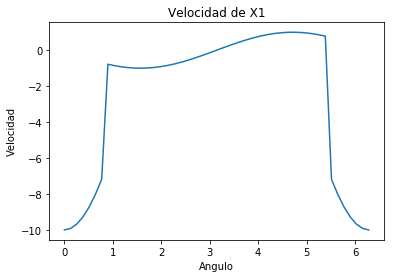

In [33]:
#PASO 4: VELOCIDAD DE X1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)
    VX1 = np.zeros((50,0))
    VY1 = np.zeros((50,0))
    VX2 = np.zeros((50,0)) 
    VY2 = np.zeros((50,0))
    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)
        
        #VX1[0,i] = qp[0]
        VX1 = np.append(VX1, qp[0])
        VY1 = np.append(VY1, qp[1])
        VX2 = np.append(VX2, qp[2])
        VY2 = np.append(VY2, qp[3])
        i=i+1
      
    print ("VX1=")
    pprint.pprint(VX1)
 
    plt.plot(th,VX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X1')

    plt.show()
    return 

grafica_velocidad (q,meca)


VY1=
array([ 1.        ,  0.99178998,  0.96729471,  0.92691642,  0.87131812,
        0.80141273,  0.7183481 ,  0.07818328,  0.0855144 ,  0.09144137,
        0.09586687,  0.09871823,  0.09994863,  0.09953787,  0.0974927 ,
        0.09384669,  0.08865971,  0.08201693,  0.07402744,  0.06482241,
        0.05455299,  0.04338781,  0.0315102 ,  0.01911519,  0.0064063 ,
       -0.00640777, -0.01911663, -0.03151159, -0.04338913, -0.05455422,
       -0.06482352, -0.07402842, -0.08201777, -0.08866039, -0.09384719,
       -0.09749302, -0.09953801, -0.09994859, -0.098718  , -0.09586645,
       -0.09144078, -0.08551364, -0.07818236,  0.71835832,  0.80142151,
        0.87132533,  0.92692193,  0.96729844,  0.99179185,  1.        ])


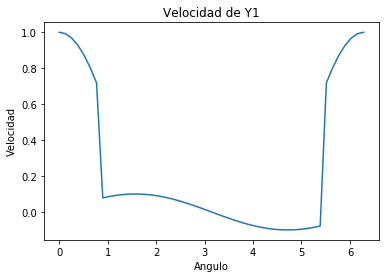

In [34]:
#PASO 4: VELOCIDAD DE Y1
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)


        VY1 = np.append(VY1, qp[1])

        i=i+1
      
    print ("VY1=")
    pprint.pprint(VY1)
 
    plt.plot(th,VY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y1')

    plt.show()
    return 

grafica_velocidad (q,meca)

VX2=
array([ 3.16129032,  3.13533605,  3.05789941,  2.93025191,  2.75448953,
        2.53349829,  2.27090689,  0.24716004,  0.27033585,  0.28907272,
        0.30306301,  0.31207699,  0.31596665,  0.31466812,  0.30820272,
        0.29667662,  0.28027908,  0.25927934,  0.23402222,  0.20492244,
        0.17245783,  0.13716145,  0.09961288,  0.06042865,  0.02025219,
       -0.02025682, -0.06043321, -0.09961729, -0.13716564, -0.17246172,
       -0.20492598, -0.23402534, -0.259282  , -0.28028123, -0.29667823,
       -0.30820376, -0.31466856, -0.3159665 , -0.31207625, -0.30306169,
       -0.28907084, -0.27033344, -0.24715715,  2.27093921,  2.53352607,
        2.75451232,  2.93026934,  3.05791119,  3.13534199,  3.16129032])


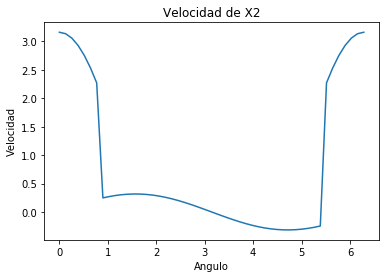

In [21]:
#PASO 4: VELOCIDAD DE X2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VX2 = np.zeros((50,0)) 
    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)


        VX2 = np.append(VX2, qp[2])

        i=i+1
      
    print ("VX2=")
    pprint.pprint(VX2)
 
    plt.plot(th,VX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de X2')

    plt.show()
    return 

grafica_velocidad (q,meca)

VY2=
array([15.80645161, 15.67668026, 15.28949704, 14.65125954, 13.77244763,
       12.66749146, 11.35453446,  1.23580022,  1.35167924,  1.44536361,
        1.51531505,  1.56038494,  1.57983323,  1.57334059,  1.54101361,
        1.48338311,  1.4013954 ,  1.2963967 ,  1.1701111 ,  1.02461222,
        0.86228916,  0.68580727,  0.49806438,  0.30214326,  0.10126093,
       -0.10128411, -0.30216606, -0.49808643, -0.68582819, -0.86230862,
       -1.0246299 , -1.17012671, -1.29640998, -1.40140614, -1.48339114,
       -1.54101878, -1.57334282, -1.57983249, -1.56038123, -1.51530844,
       -1.44535421, -1.3516672 , -1.23578574, 11.35469603, 12.66763037,
       13.7725616 , 14.65134669, 15.28955595, 15.67670995, 15.80645161])


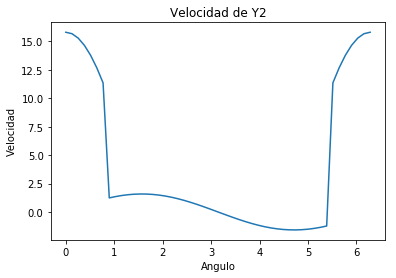

In [22]:
#PASO 4: VELOCIDAD DE Y2
def grafica_velocidad(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    #print ("th=")
    #pprint.pprint(th)

    VY2 = np.zeros((50,0))
    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qp = resuelve_prob_velocidad (q,meca)

        qp[4] = 1  #inicializar qp en 0 con qp[4] = 1 rad/s

        resuelve_prob_velocidad(q,meca)
        
        #VX1[0,i] = qp[0]

        VY2 = np.append(VY2, qp[3])
        i=i+1
      
    print ("VY2=")
    pprint.pprint(VY2)
 
    plt.plot(th,VY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Velocidad')
    plt.title ('Velocidad de Y2')

    plt.show()
    return 

grafica_velocidad (q,meca)

PASO 5: GRÁFICA ACELERACIÓN

Haremos el mismo procedimiento que para la velocidad, representando en celdas separadas la aceleración de cada coordenada.

th=
array([0.        , 0.12822857, 0.25645714, 0.38468571, 0.51291429,
       0.64114286, 0.76937143, 0.8976    , 1.02582857, 1.15405714,
       1.28228571, 1.41051429, 1.53874286, 1.66697143, 1.7952    ,
       1.92342857, 2.05165714, 2.17988571, 2.30811429, 2.43634286,
       2.56457143, 2.6928    , 2.82102857, 2.94925714, 3.07748571,
       3.20571429, 3.33394286, 3.46217143, 3.5904    , 3.71862857,
       3.84685714, 3.97508571, 4.10331429, 4.23154286, 4.35977143,
       4.488     , 4.61622857, 4.74445714, 4.87268571, 5.00091429,
       5.12914286, 5.25737143, 5.3856    , 5.51382857, 5.64205714,
       5.77028571, 5.89851429, 6.02674286, 6.15497143, 6.2832    ])
AX1=
array([-1.00000000e+03, -9.82287155e+02, -9.32806150e+02, -8.54743947e+02,
       -7.53166844e+02, -6.34689735e+02, -5.07043911e+02,  1.58344630e-01,
        3.36753490e-01,  5.09632840e-01,  6.74143994e-01,  8.27585671e-01,
        9.67438350e-01,  1.09140564e+00,  1.19745200e+00,  1.28383614e+00,
        1.34913963e+

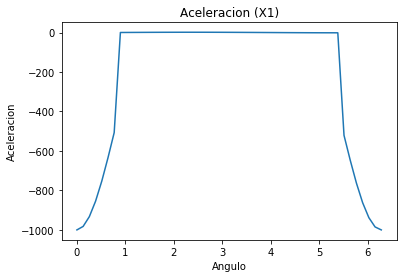

In [35]:
#PASO 5: ACELERACION DE X1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    print ("th=")
    pprint.pprint(th)
    AX1 = np.zeros((50,0))
    AY1 = np.zeros((50,0))
    AX2 = np.zeros((50,0))
    AY2 = np.zeros((50,0))
    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        
        
        AX1 = np.append(AX1, qpp[0])
        AY1 = np.append(AY1, qpp[1])
        AX2 = np.append(AX2, qpp[2])
        AY2 = np.append(AY2, qpp[3])
        i=i+1
      
    print ("AX1=")
    pprint.pprint(AX1)	
 
    plt.plot(th,AX1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X1)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)


th=
array([0.        , 0.12822857, 0.25645714, 0.38468571, 0.51291429,
       0.64114286, 0.76937143, 0.8976    , 1.02582857, 1.15405714,
       1.28228571, 1.41051429, 1.53874286, 1.66697143, 1.7952    ,
       1.92342857, 2.05165714, 2.17988571, 2.30811429, 2.43634286,
       2.56457143, 2.6928    , 2.82102857, 2.94925714, 3.07748571,
       3.20571429, 3.33394286, 3.46217143, 3.5904    , 3.71862857,
       3.84685714, 3.97508571, 4.10331429, 4.23154286, 4.35977143,
       4.488     , 4.61622857, 4.74445714, 4.87268571, 5.00091429,
       5.12914286, 5.25737143, 5.3856    , 5.51382857, 5.64205714,
       5.77028571, 5.89851429, 6.02674286, 6.15497143, 6.2832    ])
AY1=
array([-1.        , -1.11966743, -1.22094987, -1.30218426, -1.36203671,
       -1.39952446, -1.41403194, -0.6332096 , -0.77225933, -0.89547725,
       -0.99565054, -1.06703277, -1.10570649, -1.10982719, -1.07973264,
       -1.01791088, -0.9288289 , -0.81863354, -0.69474413, -0.56536374,
       -0.438941  , -0.32361764,

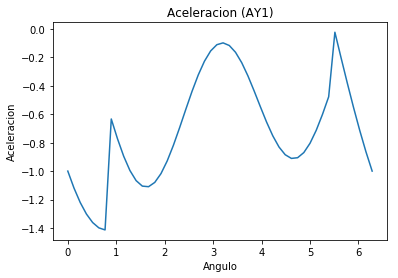

In [36]:
#PASO 5: ACELERACION DE Y1

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    print ("th=")
    pprint.pprint(th)

    AY1 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        

        AY1 = np.append(AY1, qpp[1])

        i=i+1
      
    print ("AY1=")
    pprint.pprint(AY1)
 
    plt.plot(th,AY1)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (AY1)')

    plt.show()
    return 

grafica_aceleracion (q,meca)


th=
array([0.        , 0.12822857, 0.25645714, 0.38468571, 0.51291429,
       0.64114286, 0.76937143, 0.8976    , 1.02582857, 1.15405714,
       1.28228571, 1.41051429, 1.53874286, 1.66697143, 1.7952    ,
       1.92342857, 2.05165714, 2.17988571, 2.30811429, 2.43634286,
       2.56457143, 2.6928    , 2.82102857, 2.94925714, 3.07748571,
       3.20571429, 3.33394286, 3.46217143, 3.5904    , 3.71862857,
       3.84685714, 3.97508571, 4.10331429, 4.23154286, 4.35977143,
       4.488     , 4.61622857, 4.74445714, 4.87268571, 5.00091429,
       5.12914286, 5.25737143, 5.3856    , 5.51382857, 5.64205714,
       5.77028571, 5.89851429, 6.02674286, 6.15497143, 6.2832    ])
AX1=
array([ 7.46837031e+02,  7.34194272e+02,  6.97882946e+02,  6.40262512e+02,
        5.65089376e+02,  4.77271386e+02,  3.82546961e+02,  2.58269921e+00,
        3.04318631e+00,  3.44026572e+00,  3.74528681e+00,  3.93575012e+00,
        3.99682096e+00,  3.92233868e+00,  3.71525530e+00,  3.38747389e+00,
        2.95909695e+

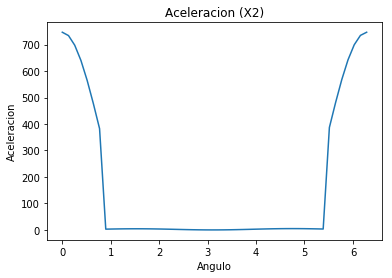

In [28]:
#PASO 5: ACELERACION DE X2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    print ("th=")
    pprint.pprint(th)

    AX2 = np.zeros((50,0))

    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        

        AX2 = np.append(AX2, qpp[2])

        i=i+1
      
    print ("AX1=")
    pprint.pprint(AX2)
 
    plt.plot(th,AX2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (X2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)


th=
array([0.        , 0.12822857, 0.25645714, 0.38468571, 0.51291429,
       0.64114286, 0.76937143, 0.8976    , 1.02582857, 1.15405714,
       1.28228571, 1.41051429, 1.53874286, 1.66697143, 1.7952    ,
       1.92342857, 2.05165714, 2.17988571, 2.30811429, 2.43634286,
       2.56457143, 2.6928    , 2.82102857, 2.94925714, 3.07748571,
       3.20571429, 3.33394286, 3.46217143, 3.5904    , 3.71862857,
       3.84685714, 3.97508571, 4.10331429, 4.23154286, 4.35977143,
       4.488     , 4.61622857, 4.74445714, 4.87268571, 5.00091429,
       5.12914286, 5.25737143, 5.3856    , 5.51382857, 5.64205714,
       5.77028571, 5.89851429, 6.02674286, 6.15497143, 6.2832    ])
AY2=
array([ 2.43499681e+03,  2.39302818e+03,  2.27381739e+03,  2.08508365e+03,
        1.83910925e+03,  1.55193716e+03,  1.24232245e+03,  4.97204469e+00,
        5.71534040e+00,  6.33813351e+00,  6.78629956e+00,  7.01778456e+00,
        7.00556493e+00,  6.73961026e+00,  6.22771716e+00,  5.49515700e+00,
        4.58315766e+

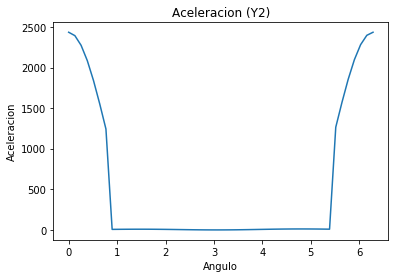

In [29]:
#PASO 5: ACELERACION DE Y2

def grafica_aceleracion(q,meca):
    
    th = np.linspace(0,2*3.1416,50)
    print ("th=")
    pprint.pprint(th)

    AY2 = np.zeros((50,0))
    
    i=0
    for t in th:

        q[4] = t
        
        resuelve_prob_posicion (q,meca)
        qpp = resuelve_prob_aceleracion(q,meca)

        qpp[4] = 1  #inicializar qp en 0 con qpp[4] = 1 rad/s**2

        resuelve_prob_aceleracion(q,meca)
        

        AY2 = np.append(AY2, qpp[3])
        i=i+1
      
    print ("AY2=")
    pprint.pprint(AY2)	
 
    plt.plot(th,AY2)
    plt.xlabel ('Angulo')
    plt.ylabel ('Aceleracion')
    plt.title ('Aceleracion (Y2)')	

    plt.show()
    return 

grafica_aceleracion (q,meca)
